# **Import necessary libraries**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

# **Question 1 --> Develop the code for Data Sets Creation**

In [2]:
def create_datasets (W,x_range,sample_size,sigma,seed):
    random_state=np.random.RandomState(seed)
    x=random_state.uniform(x_range[0],x_range[1],size=sample_size)
    X=np.zeros((sample_size,W.shape[0]))
    for i in range(sample_size):
        X[i,0]=1;
        for j in range(1,W.shape[0]):
            X[i,j]=x[i]**j;
        y=X.dot(W)
        y_no_noise=y.copy()
        if sigma > 0:
                y+=random_state.normal(0,sigma,sample_size)
    return X, y, x, y_no_noise

# **Question 2 --> Generating Training and validation samples based on different seeds**

# **Training data set**

In [3]:
seed=0
sample_size_tr=100
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1])

X_t , y_t , x_t , y_no_noise_t = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [4]:
W.shape

(4,)

In [4]:
print('x: random sample values in the interval --> the shape is: ',x_t.shape)
print('--------------------------------------------------------------------')
print('X: values of X^i for each sample point --> the shape is: ',X_t.shape)
print('--------------------------------------------------------------------')
print('Y: values of the polynomial based on x and X applying also the randome noise --> the shape is: ',y_t.shape)

x: random sample values in the interval --> the shape is:  (100,)
--------------------------------------------------------------------
X: values of X^i for each sample point --> the shape is:  (100, 4)
--------------------------------------------------------------------
Y: values of the polynomial based on x and X applying also the randome noise --> the shape is:  (100,)


# **Validation data set**

In [5]:
seed=1
sample_size_val=100
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1])

In [6]:
X_v , y_v , x_v , y_no_noise_v = create_datasets(W,x_range,sample_size_val,sigma,seed)

# **Section 3 --> Ploting 2D Training and Validation Data**

**Training Data**

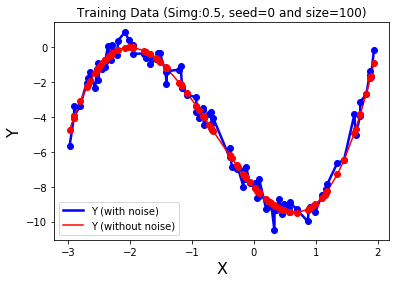

In [7]:
plt.subplots(figsize=(6,4))
plt.xlabel("X", fontsize = 16)
plt.ylabel("Y", fontsize = 16)
plt.title('Training Data (Simg:0.5, seed=0 and size=100)')

sn.lineplot(x_t,y_t, color='blue', linewidth=2.5,legend='auto')
sn.lineplot(x_t,y_no_noise_t, color='red')

plt.plot(x_t, y_t, 'bo', label='Train Data')
plt.plot(x_t, y_no_noise_t,'ro', label='Predicted')

plt.legend(['Y (with noise)','Y (without noise)'])

**Validation Data**

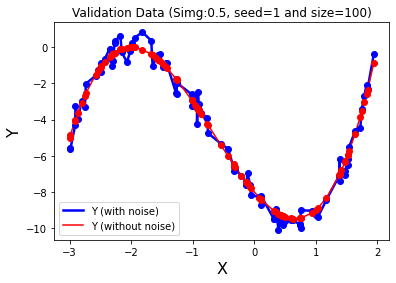

In [118]:
plt.subplots(figsize=(6,4))
plt.xlabel("X", fontsize = 16)
plt.ylabel("Y", fontsize = 16)
plt.title('Validation Data (Simg:0.5, seed=1 and size=100)')

sn.lineplot(x_v,y_v, color='blue', linewidth=2.5,legend='auto')
sn.lineplot(x_v,y_no_noise_v, color='red')

plt.plot(x_v, y_v, 'bo', label='Train Data')
plt.plot(x_v, y_no_noise_v,'ro', label='Predicted')

plt.legend(['Y (with noise)','Y (without noise)'])

# **Question 5 to 8: Polynomial regression --> model creation and Training**

**Data Preparation for training the model**

In [119]:
X_train_w4 = torch.from_numpy(X_t).float()
X_val_w4 = torch.from_numpy(X_v).float()

b_t , X_train_w3 = torch.split(torch.from_numpy(X_t).float(), [1,3], dim=1)
b_val , X_val_w3 = torch.split(torch.from_numpy(X_v).float(), [1,3], dim=1)

Y_train = torch.from_numpy(y_t.reshape((sample_size_tr , 1))).float()
Y_val = torch.from_numpy(y_v.reshape((sample_size_val , 1))).float()
# y_real = torch.from_numpy(y_no_noise_t.reshape((sample_size , 1))).float()

# **Polynomial Info**

In [120]:
W_fun = torch.FloatTensor([-8, -4, 2, 1]).unsqueeze(1) # Add Second Dimension
y_function = ' y = {} + {} * x + {} * x^2 + {} * x^3'.format(W_fun[0][0],W_fun[1][0],W_fun[2][0], W_fun[3][0])
print( '\033[1m', y_function)

  y = -8.0 + -4.0 * x + 2.0 * x^2 + 1.0 * x^3


# **A class for training the NN polynomial  models**

In [121]:
class Model_Training:
    
    losses_values = np.empty(shape=[0])
    iterations = np.empty(shape=[0])
    
    def __init__(self, model, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid ,Y_valid, loss_rate_target):
        
        self.model = model
        self.loss_func = loss_func
        self.opt = optimizer
        self.LR = Learning_Rate
        self.nr_iter = nr_itereration
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.loss_rate_target = loss_rate_target
                 
    def train(self):
        
        model = self.model 
        loss_func = self.loss_func 
        opt = self.opt 
        LR = self.LR 
        nr_iter = self.nr_iter 
        X_train = self.X_train 
        Y_train = self.Y_train 
        loss_rate_target = self.loss_rate_target
        
        for i in range(1, self.nr_iter + 1):
            # Forward pass
            y_pred = model(X_train)
            loss = loss_func(y_pred, Y_train)
            # Reset gradients
            opt.zero_grad()
            # Backward pass
            loss.backward()
            self.losses_values = np.append(self.losses_values,loss.data)
            self.iterations = np.append(self.iterations, i)
            loss_rate = 0.1
            if i > 1 :
                loss_rate = (self.losses_values[i-2]-self.losses_values[i-1])/self.losses_values[i-2]
            # update parameters
            opt.step()
            if  i == 10 :
                print('nr_iter : {}  loss : {}'.format(i,loss.data))
            if  -loss_rate_target< loss_rate < loss_rate_target:
                print('nr_iter : {}  loss : {}'.format(i,loss.data))
                print('------------------------------------')
                print('In the nr_iter : {}  the model optained a loos rate of : {} which is minor than {}'.format(i,loss_rate,loss_rate_target))
                break             
        return model.state_dict().items()

# **Model 1: considering 4 entry elemnts for weights/input data without Bias**

In [122]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_w4
Y_train = Y_train
X_valid = X_val_w4
Y_valid = Y_val

model_1_W4_no_bias = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [123]:
model_1_W4_no_bias.train()

nr_iter : 10  loss : 28.476076126098633
nr_iter : 10821  loss : 0.20682819187641144
------------------------------------
In the nr_iter : 10821  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.9901, -4.0373,  2.0538,  1.0275]]))])

**Validation of the model**

In [124]:
M_class = model_1_W4_no_bias

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.20682783424854279 and the loss value for validation data is 0.19246892631053925


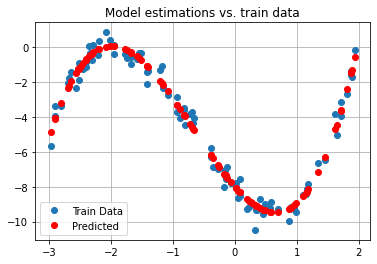

In [125]:
M_class = model_1_W4_no_bias

plt.subplots(figsize=(6,4))
plt.plot(x_t, y_t, 'o', label='Train Data')
plt.plot(x_t, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
plt.grid()
plt.legend()
plt.title('Model estimations vs. train data')
plt.show()

**Loos-value, Iteration plot**

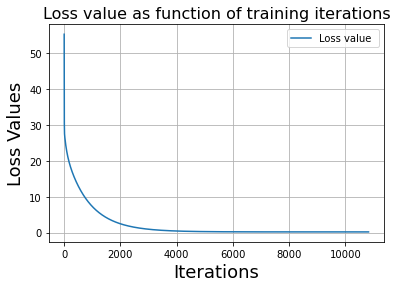

In [126]:
M_class = model_1_W4_no_bias

plt.subplots(figsize=(6,4))
plt.xlabel("Iterations", fontsize = 18)
plt.ylabel("Loss Values", fontsize = 18)

plt.title('Validation Data Generation --> Simg:0.5, seed=1 and sample-size=100')
plt.plot(M_class.iterations, M_class.losses_values , '', label='Loss value ')
plt.grid()
plt.legend()
plt.title('Loss value as function of training iterations',fontsize = 16)
plt.show()

# **Model 2: considering 4 entry elemnt for weights and input data without Bias**

In [127]:
model_ = nn.Linear(4,1, bias=True)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_w4
Y_train = Y_train
X_valid = X_val_w4
Y_valid = Y_val

model_2_W4_with_bias = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [128]:
model_2_W4_with_bias.train()

nr_iter : 10  loss : 28.409805297851562
nr_iter : 9305  loss : 0.20677684247493744
------------------------------------
In the nr_iter : 9305  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-3.9293, -4.0377,  2.0563,  1.0281]])), ('bias', tensor([-4.0677]))])

**Validation of the model**

In [129]:
M_class = model_2_W4_with_bias

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.20677657425403595 and the loss value for validation data is 0.19179794192314148


# **Model 3: considering 3 entry elemnt for weights and input data with Bias**

In [130]:
model_ = nn.Linear(3,1, bias=True)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_w3
Y_train = Y_train
X_valid = X_val_w3
Y_valid = Y_val

model_3_W3_with_bias = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [131]:
model_3_W3_with_bias.train()

nr_iter : 10  loss : 33.73591613769531
nr_iter : 10978  loss : 0.20680691301822662
------------------------------------
In the nr_iter : 10978  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-4.0385,  2.0543,  1.0278]])), ('bias', tensor([-7.9912]))])

**Validation of the model**

In [132]:
M_class = model_3_W3_with_bias

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.20680667459964752 and the loss value for validation data is 0.19225987792015076


**Define the Model**

# **Question 9: Training the model with the samples of 50, 10, 5**

**Data sets generation**

In [133]:
seed=0
sample_size_tr=50
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1])

X_t_50 , y_t_50 , x_t_50 , y_no_noise_t_50 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [134]:
seed=0
sample_size_tr=10
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1])

X_t_10 , y_t_10 , x_t_10 , y_no_noise_t_10 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [135]:
seed=0
sample_size_tr=5
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1])

X_t_5 , y_t_5 , x_t_5 , y_no_noise_t_5 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [136]:
X_train_50 = torch.from_numpy(X_t_50).float()
X_train_10 = torch.from_numpy(X_t_10).float()
X_train_5 = torch.from_numpy(X_t_5).float()

Y_train_50 = torch.from_numpy(y_t_50.reshape((50 , 1))).float()
Y_train_10 = torch.from_numpy(y_t_10.reshape((10 , 1))).float()
Y_train_5 = torch.from_numpy(y_t_5.reshape((5 , 1))).float()


# **Training the model with the data sample of size 50**

In [137]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_50
Y_train = Y_train_50
X_valid = X_val_w4
Y_valid = Y_val

model_W4_DS_50 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [138]:
model_W4_DS_50.train()

nr_iter : 10  loss : 37.12452697753906
nr_iter : 10522  loss : 0.19118940830230713
------------------------------------
In the nr_iter : 10522  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.7929, -3.9551,  1.8446,  0.9587]]))])

**Validation of the model**

In [139]:
M_class = model_W4_DS_50

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.19118890166282654 and the loss value for validation data is 0.24908114969730377


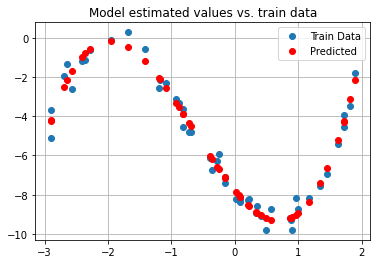

In [140]:
M_class = model_W4_DS_50

plt.subplots(figsize=(6,4))
plt.plot(x_t_50, y_t_50, 'o', label='Train Data')
plt.plot(x_t_50, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

**Loos-value, Iteration plot**

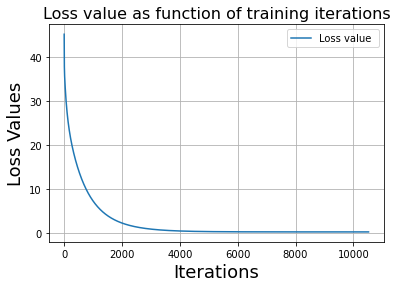

In [141]:
M_class = model_W4_DS_50

plt.subplots(figsize=(6,4))
plt.xlabel("Iterations", fontsize = 18)
plt.ylabel("Loss Values", fontsize = 18)

plt.title('Validation Data Generation --> Simg:0.5, seed=1 and sample-size=100')
plt.plot(M_class.iterations, M_class.losses_values , '', label='Loss value ')
plt.grid()
plt.legend()
plt.title('Loss value as function of training iterations',fontsize = 16)
plt.show()

# **Training the model with the data sample of size 10**

In [142]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 50000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_10
Y_train = Y_train_10
X_valid = X_val_w4
Y_valid = Y_val

model_W4_DS_10 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [143]:
model_W4_DS_10.train()

nr_iter : 10  loss : 40.18901062011719
nr_iter : 20968  loss : 0.384787380695343
------------------------------------
In the nr_iter : 20968  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.8603, -4.6559,  1.7359,  1.4406]]))])

**Validation of the model**

In [144]:
M_class = model_W4_DS_10

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.3847866654396057 and the loss value for validation data is 14.312583923339844


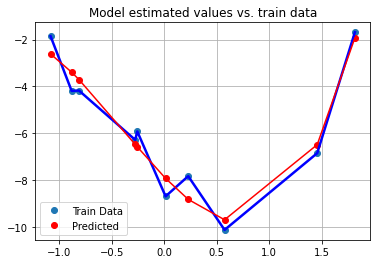

In [145]:
M_class = model_W4_DS_10

plt.subplots(figsize=(6,4))
plt.plot(x_t_10, y_t_10, 'o', label='Train Data')
plt.plot(x_t_10, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
sn.lineplot(x_t_10, y_t_10, color='blue', linewidth=2.5,legend='auto')
sn.lineplot(x_t_10, np.array(M_class.model(M_class.X_train).data).flatten(), color='red')
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

# **Training the model with the data sample of size 5**

In [146]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_5
Y_train = Y_train_5
X_valid = X_val_w4
Y_valid = Y_val

model_W4_DS_5 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [147]:
model_W4_DS_5.train()

nr_iter : 10  loss : 52.09187698364258
nr_iter : 9374  loss : 0.09403707087039948
------------------------------------
In the nr_iter : 9374  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.3583, -3.1723,  0.2252, -1.5225]]))])

**Validation of the model**

In [148]:
M_class = model_W4_DS_5

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.094036765396595 and the loss value for validation data is 267.8866271972656


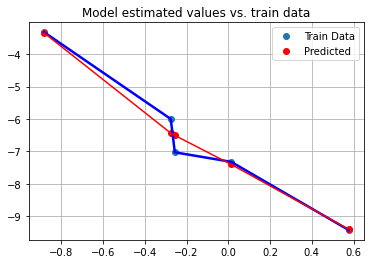

In [149]:
M_class = model_W4_DS_5

plt.subplots(figsize=(6,4))
plt.plot(x_t_5, y_t_5, 'o', label='Train Data')
plt.plot(x_t_5, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
sn.lineplot(x_t_5, y_t_5, color='blue', linewidth=2.5,legend='auto')
sn.lineplot(x_t_5, np.array(M_class.model(M_class.X_train).data).flatten(), color='red')
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

# **Question 10: Training the model with data samples generated by sigma: 2, 4 , 8**

**Data sets generation**

In [150]:
seed=0
sample_size_tr=100
x_range=[-3,2]
sigma=2
W=np.array([-8,-4,2,1])

X_t_s2 , y_t_s2 , x_t_s2 , y_no_noise_t_s2 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [151]:
seed=0
sample_size_tr=100
x_range=[-3,2]
sigma=4
W=np.array([-8,-4,2,1])

X_t_s4 , y_t_s4 , x_t_s4 , y_no_noise_t_s4 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [152]:
seed=0
sample_size_tr=100
x_range=[-3,2]
sigma=8
W=np.array([-8,-4,2,1])

X_t_s8 , y_t_s8 , x_t_s8 , y_no_noise_t_s8 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [153]:
X_train_s2 = torch.from_numpy(X_t_s2).float()
X_train_s4 = torch.from_numpy(X_t_s4).float()
X_train_s8 = torch.from_numpy(X_t_s8).float()

Y_train_s2 = torch.from_numpy(y_t_s2.reshape((100 , 1))).float()
Y_train_s4 = torch.from_numpy(y_t_s4.reshape((100 , 1))).float()
Y_train_s8 = torch.from_numpy(y_t_s8.reshape((100 , 1))).float()


# **Training the model with the data sample of sigma = 2**

In [154]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_s2
Y_train = Y_train_s2
X_valid = X_val_w4
Y_valid = Y_val

model_W4_DS_s2 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [155]:
model_W4_DS_s2.train()

nr_iter : 10  loss : 39.754127502441406
nr_iter : 9389  loss : 3.3077516555786133
------------------------------------
In the nr_iter : 9389  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.9838, -4.1740,  2.2267,  1.1168]]))])

**Validation of the model**

In [156]:
M_class = model_W4_DS_s2

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 3.3077499866485596 and the loss value for validation data is 0.33012256026268005


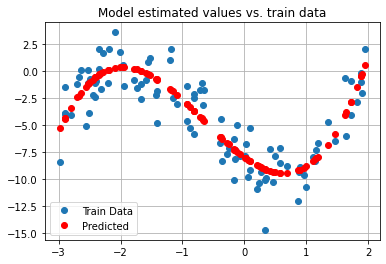

In [157]:
M_class = model_W4_DS_s2

plt.subplots(figsize=(6,4))
plt.plot(x_t_s2, y_t_s2, 'o', label='Train Data')
plt.plot(x_t_s2, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

**Loos-value, Iteration plot**

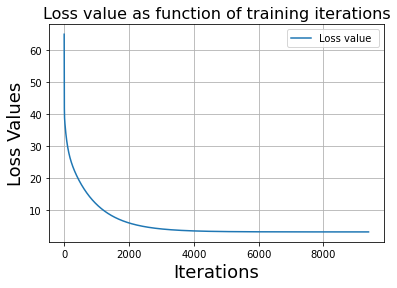

In [158]:
M_class = model_W4_DS_s2

plt.subplots(figsize=(6,4))
plt.xlabel("Iterations", fontsize = 18)
plt.ylabel("Loss Values", fontsize = 18)

plt.title('Validation Data Generation --> Simg:0.5, seed=1 and sample-size=100')
plt.plot(M_class.iterations, M_class.losses_values , '', label='Loss value ')
plt.grid()
plt.legend()
plt.title('Loss value as function of training iterations',fontsize = 16)
plt.show()

# **Training the model with the data sample of sigma = 4**

In [159]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_s4
Y_train = Y_train_s4
X_valid = X_val_w4
Y_valid = Y_val

model_W4_DS_s4 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [160]:
model_W4_DS_s4.train()

nr_iter : 10  loss : 43.45909118652344
nr_iter : 8105  loss : 13.230720520019531
------------------------------------
In the nr_iter : 8105  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.9703, -4.3514,  2.4549,  1.2346]]))])

**Validation of the model**

In [161]:
M_class = model_W4_DS_s4

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 13.23071575164795 and the loss value for validation data is 0.8160218596458435


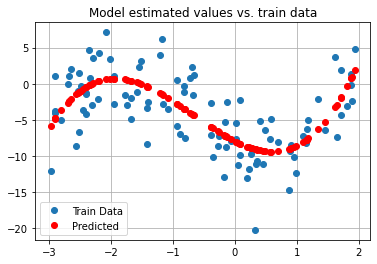

In [162]:
M_class = model_W4_DS_s4

plt.subplots(figsize=(6,4))
plt.plot(x_t_s4, y_t_s4, 'o', label='Train Data')
plt.plot(x_t_s4, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

# **Training the model with the data sample of sigma = 8**

In [163]:
model_ = nn.Linear(4,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 20000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_s8
Y_train = Y_train_s8
X_valid = X_val_w4
Y_valid = Y_val

model_W4_DS_s8 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [164]:
model_W4_DS_s8.train()

nr_iter : 10  loss : 81.72650146484375
nr_iter : 7166  loss : 52.92034149169922
------------------------------------
In the nr_iter : 7166  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.9549, -4.7182,  2.9169,  1.4734]]))])

**Validation of the model**

In [165]:
M_class = model_W4_DS_s8

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 52.92032241821289 and the loss value for validation data is 2.8252859115600586


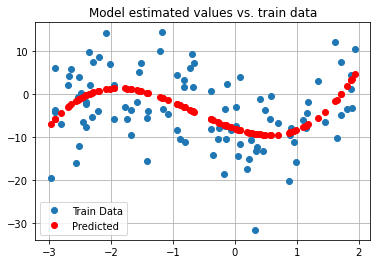

In [166]:
M_class = model_W4_DS_s8

plt.subplots(figsize=(6,4))
plt.plot(x_t_s8, y_t_s8, 'o', label='Train Data')
plt.plot(x_t_s8, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

# **Question 11 (Bonus): Training the model with data samples generated by sigma: 2, 4 , 8**

# **Define a model of polynomial degree 4 (W:5) and train the model with the data sample of size 10**

**5 dimention Data Set generation ( with 10 samples)**

In [167]:
seed=0
sample_size_tr=10
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1,0])

X_t_w5_s10 , y_t_w5_s10 , x_t_w5_s10 , y_no_noise_w5_s10 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [168]:
seed=1
sample_size_tr=100
x_range=[-3,2]
sigma=0.5
W=np.array([-8,-4,2,1,0])

X_v_w5 , y_v_w5 , x_v_w5 , y_no_noise_w5 = create_datasets(W,x_range,sample_size_tr,sigma,seed)

In [169]:
X_train_w5_s10 = torch.from_numpy(X_t_w5_s10).float()
Y_train_10 = torch.from_numpy(y_t_w5_s10.reshape((10 , 1))).float()

X_valid_w5 = torch.from_numpy(X_v_w5).float()
Y_valid_w5 = torch.from_numpy(y_v_w5.reshape((100 , 1))).float()


In [170]:
model_ = nn.Linear(5,1, bias=False)
Learning_Rate = 1e-3
nr_itereration = 50000
loss_rate_target = 1e-8
loss_func  =  nn.MSELoss()
optimizer  =  optim.SGD(model_.parameters(),  lr=Learning_Rate)

X_train = X_train_w5_s10
Y_train = Y_train_10
X_valid = X_valid_w5
Y_valid = Y_valid_w5

model_W5_DS_10 = Model_Training( model_, loss_func, optimizer, Learning_Rate, nr_itereration, X_train, Y_train, X_valid, Y_valid, loss_rate_target)

In [171]:
model_W5_DS_10.train()

nr_iter : 10  loss : 35.098724365234375
nr_iter : 38552  loss : 0.30217689275741577
------------------------------------
In the nr_iter : 38552  the model optained a loos rate of : 0.0 which is minor than 1e-08


odict_items([('weight', tensor([[-7.6588, -3.7173,  0.4966,  0.2684,  0.8806]]))])

**Validation of the model**

In [172]:
M_class = model_W5_DS_10

y_pred_val = M_class.model(M_class.X_valid)
y_pred_train = M_class.model(M_class.X_train)
loss_of_validation = M_class.loss_func( y_pred_val, M_class.Y_valid )
loss_of_training = M_class.loss_func( y_pred_train, M_class.Y_train )
print('for Model 1 the loss value for training data is \033[1m + {} and the loss value for validation data is {}'.format(loss_of_training,loss_of_validation))

for Model 1 the loss value for training data is  + 0.3021765351295471 and the loss value for validation data is 475.9212646484375


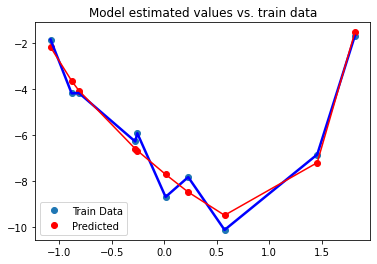

In [173]:
M_class = model_W5_DS_10

plt.subplots(figsize=(6,4))
plt.plot(x_t_w5_s10, y_t_w5_s10, 'o', label='Train Data')
plt.plot(x_t_w5_s10, M_class.model(M_class.X_train).data.numpy(),'ro', label='Predicted')
sn.lineplot(x_t_w5_s10, y_t_w5_s10, color='blue', linewidth=2.5,legend='auto')
sn.lineplot(x_t_w5_s10, np.array(M_class.model(M_class.X_train).data).flatten(), color='red')
plt.grid()
plt.grid()
plt.legend()
plt.title('Model estimated values vs. train data')
plt.show()

**Loos-value, Iteration plot**

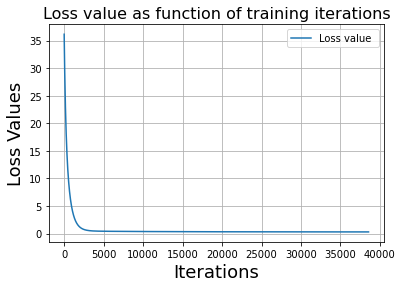

In [174]:
M_class = model_W5_DS_10

plt.subplots(figsize=(6,4))
plt.xlabel("Iterations", fontsize = 18)
plt.ylabel("Loss Values", fontsize = 18)

plt.title('Validation Data Generation --> Simg:0.5, seed=1 and sample-size=100')
plt.plot(M_class.iterations, M_class.losses_values , '', label='Loss value ')
plt.grid()
plt.legend()
plt.title('Loss value as function of training iterations',fontsize = 16)
plt.show()